# Keras transfer learning

Tuan Do, 2021-11-06

Goal: follow the Keras transfer learning example at https://keras.io/guides/transfer_learning/ and see if we can do a small test with the photometric redshifts with images.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from astropy.io import fits

import pandas as pd
import pylab as plt
import h5py

import matplotlib

font = {        'size'   : 20}
matplotlib.rc('font', **font)

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


First, load the Xception network, but without the top layer so that we can specify any image size (needs to be bigger than 71 pixels). 

https://keras.io/api/applications/xception/

In [2]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(127, 127, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 1s 0us/step


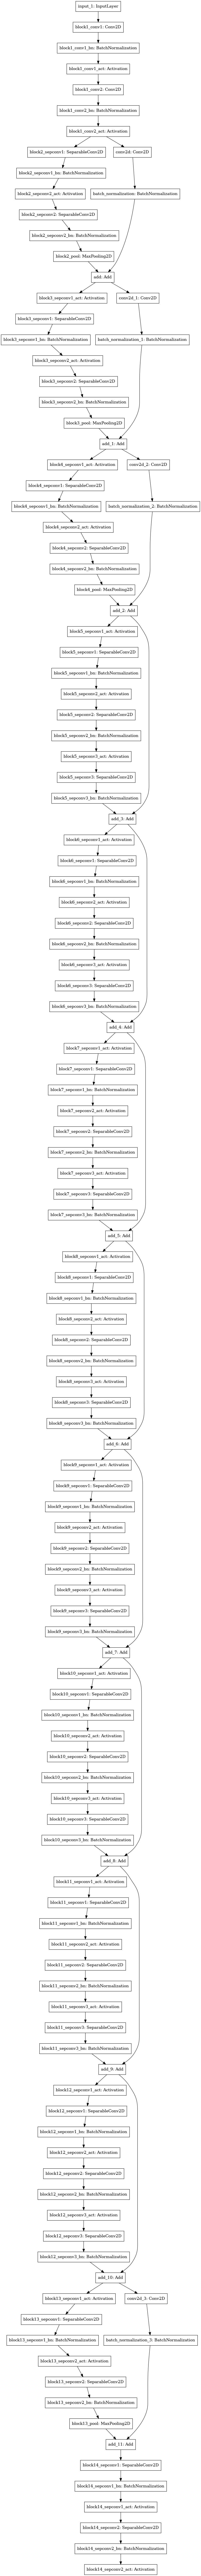

In [9]:
# Let's visualize the layers of this model
tf.keras.utils.plot_model(base_model)

In [10]:
# freeze the model so that we are not training over the pre-trained model
base_model.trainable = False

## Building on top of the pretrained model
Here, we add in an input layer on top of the pre-trained model. 

## Cats and Dogs example

Run the example from Keras 

In [3]:
# Download the dataset first
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


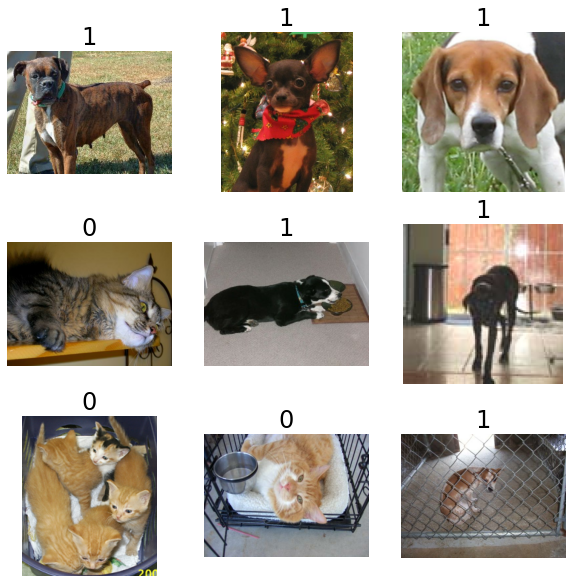

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [5]:
# resize all the images to 150x150

size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [6]:
# batch the data and use pre-fetching
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Data augmentation

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# note: the location of this processing seems to be different than in the official instructions where 
# it is layers.RandomFlip, etc. Is this a tensorflow version problem?
from tensorflow.python.keras.layers.preprocessing import image_preprocessing

data_augmentation = keras.Sequential(
    [image_preprocessing.RandomFlip("horizontal"), image_preprocessing.RandomRotation(0.1),]
)

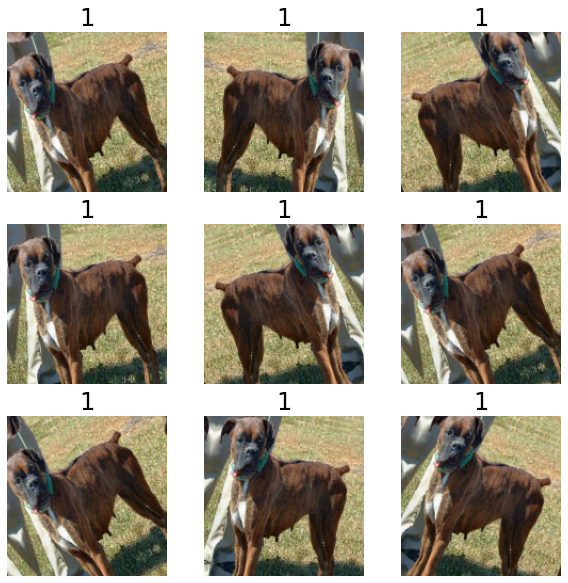

In [8]:
# visualize what the image augmentation looks like
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


## Build the model

Use the Xception network to start and build on the new dataset and image augmentation

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = image_preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [10]:
# train only the top layer of the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
model.save_weights('xception_checkpoint')

Epoch 1/20
291/291 [==============================] - 291s 29ms/step - loss: 0.1746 - binary_accuracy: 0.9218 - val_loss: 0.0820 - val_binary_accuracy: 0.9652
Epoch 2/20
291/291 [==============================] - 7s 25ms/step - loss: 0.1145 - binary_accuracy: 0.9505 - val_loss: 0.0764 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 7s 25ms/step - loss: 0.1135 - binary_accuracy: 0.9517 - val_loss: 0.0769 - val_binary_accuracy: 0.9686
Epoch 4/20
291/291 [==============================] - 7s 25ms/step - loss: 0.1080 - binary_accuracy: 0.9557 - val_loss: 0.0747 - val_binary_accuracy: 0.9708
Epoch 5/20
291/291 [==============================] - 7s 25ms/step - loss: 0.0995 - binary_accuracy: 0.9589 - val_loss: 0.0758 - val_binary_accuracy: 0.9699
Epoch 6/20
291/291 [==============================] - 7s 25ms/step - loss: 0.1019 - binary_accuracy: 0.9583 - val_loss: 0.0736 - val_binary_accuracy: 0.9738
Epoch 7/20
291/291 [==============================] - 7s

### Unfreeze the model and re-train
We can try to improve it by retraining at a slow learning rate

In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
model.save_weights('xception_checkpoint2')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  